In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate, UnitaryGate
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import array_to_latex
from qiskit.circuit.library import QFT

## Phase Estimation Problem

A unitary gate $U$ operates on a $n$ bit qubit state $|\psi\rangle$ which is an eigenvector of $U$. What is the eigenvalue corresponding to this eigenvector? Since the eigenvalues of a unitary operator lie on the unit circle, we want to know the phase of this eigenvalue. In other words, what is $\theta$, such that
$$U|\psi\rangle = e^{2\pi i\theta}|\psi\rangle$$

### Low-precision version

Consider the state $|\pi_0\rangle = |\psi\rangle|0\rangle$.

We first start by placing $|0\rangle$ in an equal superposition of $|0\rangle$ and $|1\rangle$ via a Hadamard operation, yielding

$$|\pi_1\rangle = \mathbb 1 \otimes H|\pi_0\rangle = \frac{1}{\sqrt2}|\psi\rangle(|0\rangle + |1\rangle)$$

Utilizing phase kickback, we can apply a controlled unitary transformation $U$ to $|\psi\rangle$ where the rightmost bit is the control bit, yielding

$$|\pi_2\rangle = \frac{1}{\sqrt2}|\psi\rangle|0\rangle + \frac{1}{\sqrt2}(U|\psi\rangle)|1\rangle$$
$$= \frac{1}{\sqrt2}|\psi\rangle|0\rangle + \frac{e^{2\pi i \theta}}{\sqrt2}|\psi\rangle|1\rangle$$
$$= |\psi\rangle\left(\frac{1}{\sqrt2}|0\rangle + \frac{e^{2\pi i \theta}}{\sqrt2}|1\rangle\right)$$

Taking advantage of the phase difference between the $|0\rangle$ and $|1\rangle$ terms via interference, we can apply a Hadamard transform again, yielding

$$|\pi_3\rangle = \mathbb 1 \otimes H|\pi_2\rangle = |\psi\rangle\left(\frac{1 + e^{2\pi i \theta}}{2}|0\rangle + \frac{1 - e^{2\pi i \theta}}{2}|1\rangle\right)$$

Measuring the probability of each outcome for the rightmost bit by taking the square of the absolute value of each probability amplitude, we have that

$$p(x = 0) = \cos^2(\pi \theta)$$
$$p(x = 1) = \sin^2(\pi \theta)$$

Hence, we can see that when $\theta = 0$, we will always measure $x = 0$ and when $\theta = 1/2$, we will always measure $x = 1$. For any other value of $\theta$, we have a nonzero chance of error. Since 0.0 and 0.1 correspond to 0 and 1/2 in binary, respectively, we can see that this procedure attempts to measure the phase to one bit of accuracy.

### Implementation

In [5]:
def low_precision(theta):
    """
    Estimating phase to 1 bit of accuracy
    """
    qc = QuantumCircuit(2, 1)
    qc.x(1)
    qc.barrier()
    qc.h(0)
    qc.barrier()
    qc.cp(2 * np.pi * theta, 0, 1)
    qc.barrier()
    qc.h(0)
    qc.measure(0, 0)
    display(qc.draw('mpl'))
    
    # Calculate predicted results
    print("Theoretical probabilities of measuring 0 and 1:")
    display({
        0: np.cos(np.pi * theta) ** 2,
        1: np.sin(np.pi * theta) ** 2
    })
    return qc

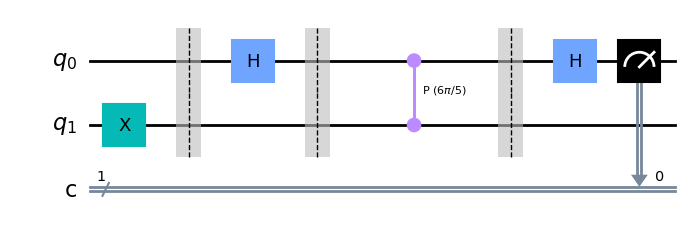

Theoretical probabilities of measuring 0 and 1:


{0: 0.09549150281252623, 1: 0.9045084971874738}

Experimental probabilities of measuring 0 and 1:


{1: 0.9169921875, 0: 0.0830078125}

In [8]:
# Creating quantum circuit that measures the 
qc = low_precision(0.6)

print("Experimental probabilities of measuring 0 and 1:")
results = Sampler().run(qc).result().quasi_dists[0]
display(results)

### Two-qubit phase estimation

In order to acquire a more precise estimate of the eigenvalue phase, we can apply the unitary operation $U$ twice, since the eigenvalue of $U^2$ is $e^{2\pi i (2\theta)}$, we are effectively measuring the "half bit" of $2\theta$. In other words, if $\theta = 0.a_1a_2...$, where $a_i \in \{0, 1\}, \forall i \in \mathbb N$, we have that $2\theta = a_1.a_2a_3...$, meaning that we are effectively calculating $a_2$. Hence, we can observe that in general, by applying the unitary gate $U$ a total of $2^{n - 1}$ times, we can retrieve a prediction for the $n$th bit after the decimal point. Hence, since $\sum_{k = 1} ^n 2^{k - 1} = 2^{n} - 1$, we have that in order to estimate $n$ digits of the phase, we need to perform $2^n - 1$ applications of the unitary transformation. 

Let's look at the case where $n = 2$.

Assume an initial state $|\pi_0\rangle = |\psi\rangle|00\rangle$. Applying a Hadamard transformation to the $|0\rangle$ qubits yields the following superposition:

$$|\pi_1\rangle = \mathbb 1 \otimes H^{\otimes 2}|\pi_0\rangle = \frac{1}{2}|\psi\rangle\sum_{a_0 = 0} ^1\sum_{a_1 = 0} ^1|a_1a_0\rangle$$

Applying a controlled $U$ gate using the $a_0$ bit as a control once $(|\pi_2\rangle)$ and the $a_1$ bit as the control twice $(|\pi_3\rangle)$ yields

$$|\pi_2\rangle = \frac{1}{2}|\psi\rangle\sum_{a_0 = 0} ^1\sum_{a_1 = 0} ^1e^{2\pi ia_0\theta}|a_1a_0\rangle$$

$$|\pi_3\rangle = \frac{1}{2}|\psi\rangle\sum_{a_0 = 0} ^1\sum_{a_1 = 0} ^1e^{2\pi i(a_0 + 2a_1)\theta}|a_1a_0\rangle$$

Using decimal integers, this effectively becomes

$$|\pi_3\rangle = \frac{1}{2}|\psi\rangle\sum_{x = 0} ^3e^{2\pi ix\theta}|x\rangle$$

If we assume that $\theta = y/4$, such that $y \in \{0, 1, 2, 3\}$, we have that

$$|\pi_3\rangle = \frac{1}{2}|\psi\rangle\sum_{x = 0} ^3e^{2\pi i(xy/4)}|x\rangle$$

We can describe the sum of exponentials as a map from $|y\rangle$ (where $y$ is represented in binary), giving us that

$$|y\rangle \mapsto \begin{pmatrix}
1 \\
e^{2\pi i(y/4)} \\
e^{2\pi i(y/2)} \\
e^{2\pi i(3y/4)} \\
\end{pmatrix}$$

Expanding out this transoformation for all $y$, we end up with the following matrix, referred to as the 4 dimensional **Quantum Fourier Transform** matrix:

$$\text{QFT}_4 = \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & i & -1 & -i \\
1 & -1 & 1 & -1 \\
1 & -i & -1 & i \\
\end{pmatrix}$$

Since this matrix is a map from the standard basis for a two-qubit system to the four deterministic outputs of $|\pi_3\rangle$, we need to apply the inverse of this matrix (which is simple the complex conjugate since this matrix is unitary) in order to recover the approximation of the phase ($\theta = 0, 1/4, 1/2, 3/4$).

### Implementation

In [84]:
def double_precision(theta):
    """
    Estimating phase to 2 bits of accuracy
    """
    qc = QuantumCircuit(3, 2)
    qc.x(2)
    qc.barrier()
    qc.h(range(2))
    qc.barrier()
    qc.cp(2 * np.pi * theta, 0, 2)
    qc.cp(4 * np.pi * theta, 1, 2)
    qc.barrier()
    
    # QFT
    qc.swap(0, 1)
    qc.h(0)
    qc.cp(-np.pi/2, 0, 1)
    qc.h(1)
    
    qc.measure(0, 0)
    qc.measure(1, 1)
    display(qc.draw('mpl'))
    return qc

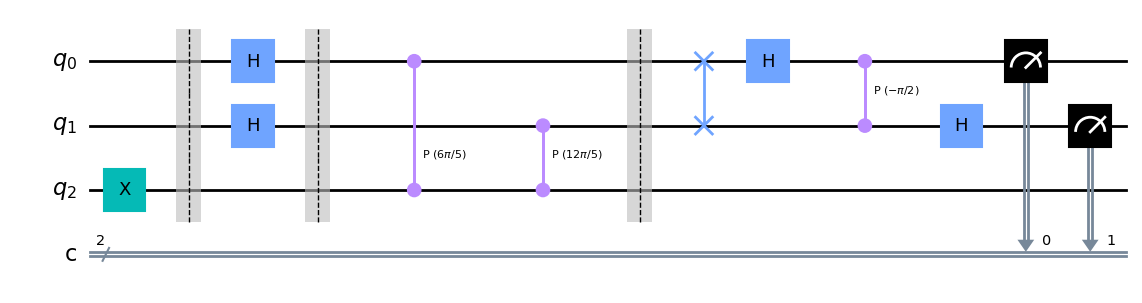

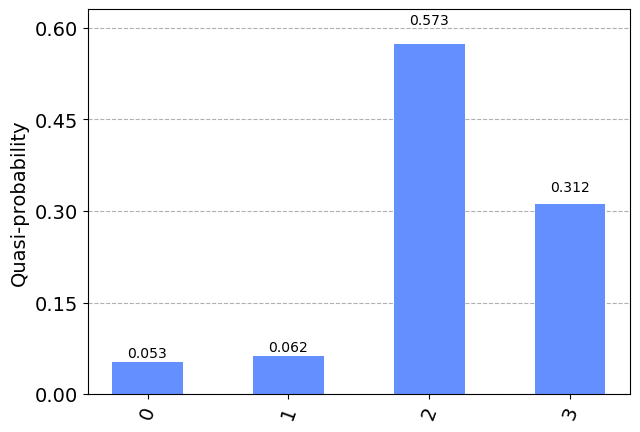

In [119]:
qc = double_precision(0.6)
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

### Implementing QFT

In order to implement the Quantum Fourier Transform in terms of more elementary gates, we can use phase and controlled phase gates. Namely, using the following recursive definition, we can implement QFT of size $2^m$ recursively. In order to this, we need to apply the following transformation
$$|y\rangle|a\rangle \mapsto \omega_{2^m}^{ay}|y\rangle|a\rangle$$
where $y$ is a number encoded in $m - 1$ bits and $\omega_N := e^{\frac{2\pi i}{N}}$ is the wiggle factor.

We have the following procedure:

1. First, if $m > 0$ recursively apply the $2^{m-1}$ QFT to the leftmost qubits, where QFT is the Hadamard for the base case $m = 0$, giving us the state

$$(\text{QFT}_{2^{m - 1}}|x\rangle)|a\rangle = \frac{1}{\sqrt{2^{m - 1}}}\sum_{y = 0} ^{2^{m - 1} - 1}\omega_{2^{m - 1}}^{xy}|y\rangle|a\rangle$$

2. Next, apply the transformation described earlier ($|y\rangle|a\rangle \mapsto \omega_{2^m}^{ay}|y\rangle|a\rangle$) using $a$ as the control as before. This yields the state

$$\frac{1}{\sqrt{2^{m - 1}}}\sum_{y = 0} ^{2^{m - 1} - 1}\omega_{2^{m-1}}^{xy}\omega_{2^m}^{ay}|y\rangle|a\rangle$$

3. Perform a Hadamard operation on the control bit to get the state

$$\frac{1}{\sqrt{2^{m}}}\sum_{y = 0} ^{2^{m - 1} - 1}\sum_{b = 0} ^{1}\omega_{2^{m-1}}^{xy}\omega_{2^m}^{ay}(-1)^{ab}|y\rangle|b\rangle$$

4. Now permute the state such that $|b\rangle$ is now on the other side of $|y\rangle$ to arrive at the state

$$\frac{1}{\sqrt{2^{m}}}\sum_{y = 0} ^{2^{m - 1} - 1}\sum_{b = 0} ^{1}\omega_{2^{m-1}}^{xy}\omega_{2^m}^{ay}(-1)^{ab}|b\rangle|y\rangle$$

To show that this gives the desired result, we can rewrite the coefficient in the sum as follows:

$$\omega_{2^{m-1}}^{xy}\omega_{2^m}^{ay}(-1)^b = (\omega_{2^m}^{2^{m}})^{xb}\omega_{2^{m-1}}^{xy}\omega_{2^m}^{ay}(\omega_{2^m}^{2^{m - 1}})^{ab} = \omega_{2^m}^{(2x + a)(2^{m - 1}b + y)}$$

using the fact that $\omega_{2^m}^{2^{m}} = 1$ and $\omega_{2^m}^{2^{m - 1}} = -1$. Letting $u = 2x + a$ and $v = 2^{m - 1}b + y$, we can combine the two sums into the following:

$$\frac{1}{\sqrt{2^{m}}}\sum_{y = 0} ^{2^{m - 1} - 1}\sum_{b = 0} ^{1}\omega_{2^m}^{(2x + a)(2^{m - 1}b + y)}|b\rangle|y\rangle = \frac{1}{\sqrt{2^{m}}}\sum_{v = 0} ^{2^{m} - 1}\omega_{2^m}^{uv}|b\rangle|y\rangle$$

Furthermore, since $|b\rangle|y\rangle = |2^{m - 1}b + y\rangle$, we have that

$$\frac{1}{\sqrt{2^{m}}}\sum_{v = 0} ^{2^{m} - 1}\omega_{2^m}^{uv}|b\rangle|y\rangle = \frac{1}{\sqrt{2^{m}}}\sum_{v = 0} ^{2^{m} - 1}\omega_{2^m}^{uv}|v\rangle$$

which is the definition of Fourier transform.

In [65]:
def qft(m):
    """
    Quantum Fourier Transform implementation in terms of more elementary gates
    """
    # initialize circuit
    qc = QuantumCircuit(m)
    
    # base case
    if m == 1:
        qc.h(0)
    
    # recursive case
    else:
        # recursively append QFT for smaller m (step 1)
        prev = qft(m - 1)
        qc.compose(prev, range(1, m), inplace=True)
        
        # step 2
        for i in range(1, m):
            qc.cp(np.pi / (2 ** (m - i)), 0, i)
            
        # step 3
        qc.h(0)
        
        # step 4
        qc.swap(0, m - 1)
        for i in range(1, m - 1):
            qc.swap(i - 1, i)
    return qc

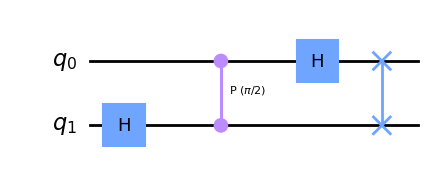

Operator([[ 5.000000e-01+0.j ,  5.000000e-01+0.j ,  5.000000e-01+0.j ,
            5.000000e-01+0.j ],
          [ 5.000000e-01+0.j ,  3.061617e-17+0.5j, -5.000000e-01+0.j ,
           -3.061617e-17-0.5j],
          [ 5.000000e-01+0.j , -5.000000e-01+0.j ,  5.000000e-01+0.j ,
           -5.000000e-01+0.j ],
          [ 5.000000e-01+0.j , -3.061617e-17-0.5j, -5.000000e-01+0.j ,
            3.061617e-17+0.5j]],
         input_dims=(2, 2), output_dims=(2, 2))


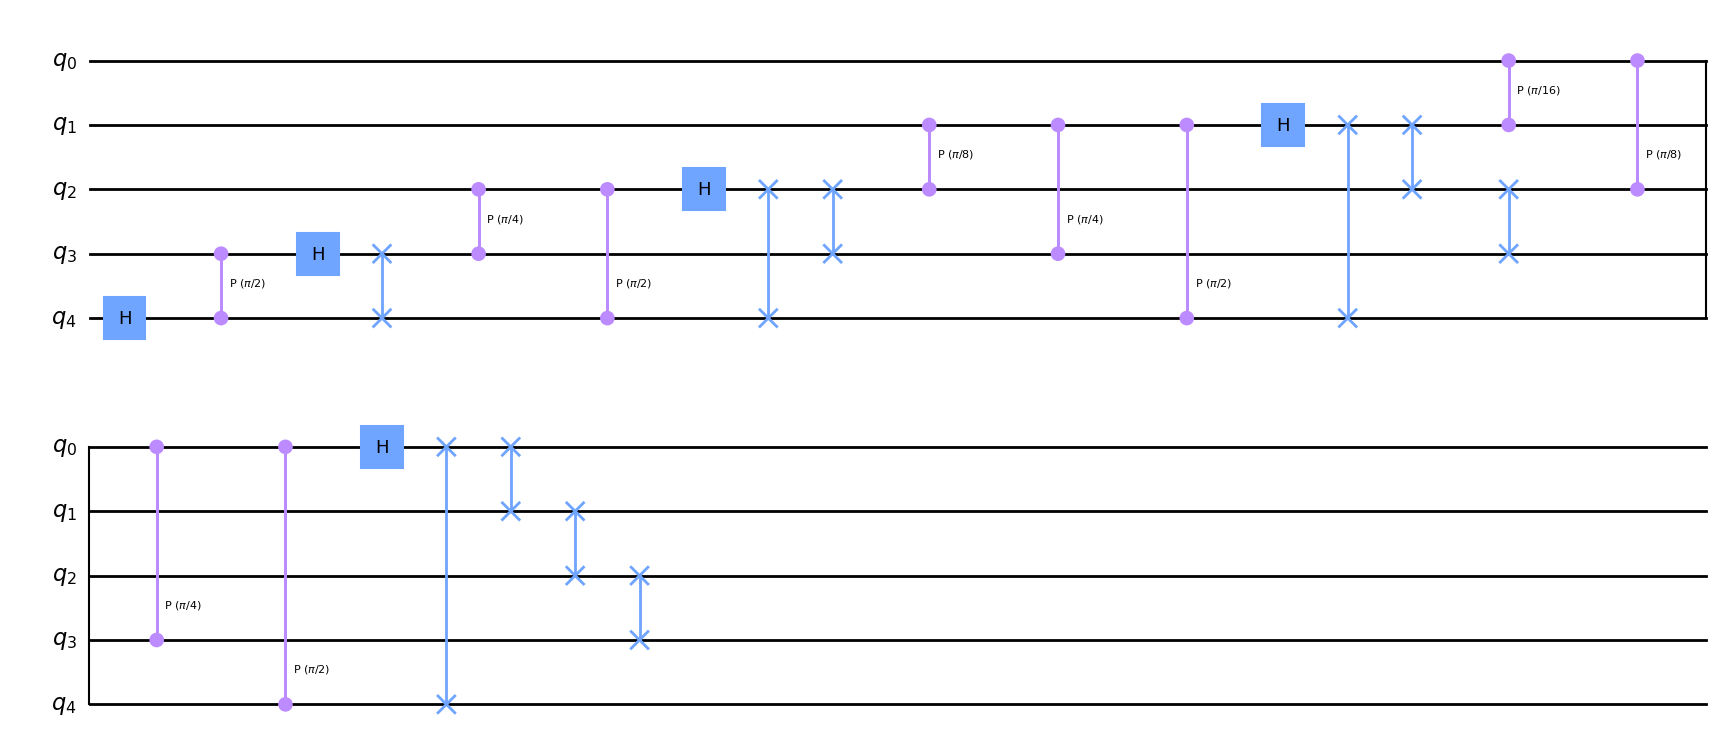

In [68]:
# Example of QFT-4 for two qubits with matrix printed to compare with that derived for the double precision problem
qc = qft(2)
display(qc.draw('mpl'))
display(Operator(qc))

# Example of QFT-32 for five qubits
qc = qft(5)
display(qc.draw('mpl'))

### General phase estimation procedure

We can extend the derivation that we performed for two qubits to $n$ qubits as follows:

In [71]:
def phase_estimation(m, theta):
    """
    Generalized phase estimation example
    """
    qc = QuantumCircuit(m + 1, m)
    qc.x(m)
    qc.barrier()
    qc.h(range(m))
    qc.barrier()
    
    for i in range(m):
        qc.cp(2 ** (i + 1) * np.pi * theta, i, m)
    qc.barrier()
    
    # QFT
    qc.compose(
        QFT(m, inverse=True),
        inplace=True
    )
    qc.measure(range(m), range(m))
    display(qc.draw('mpl'))
    return qc

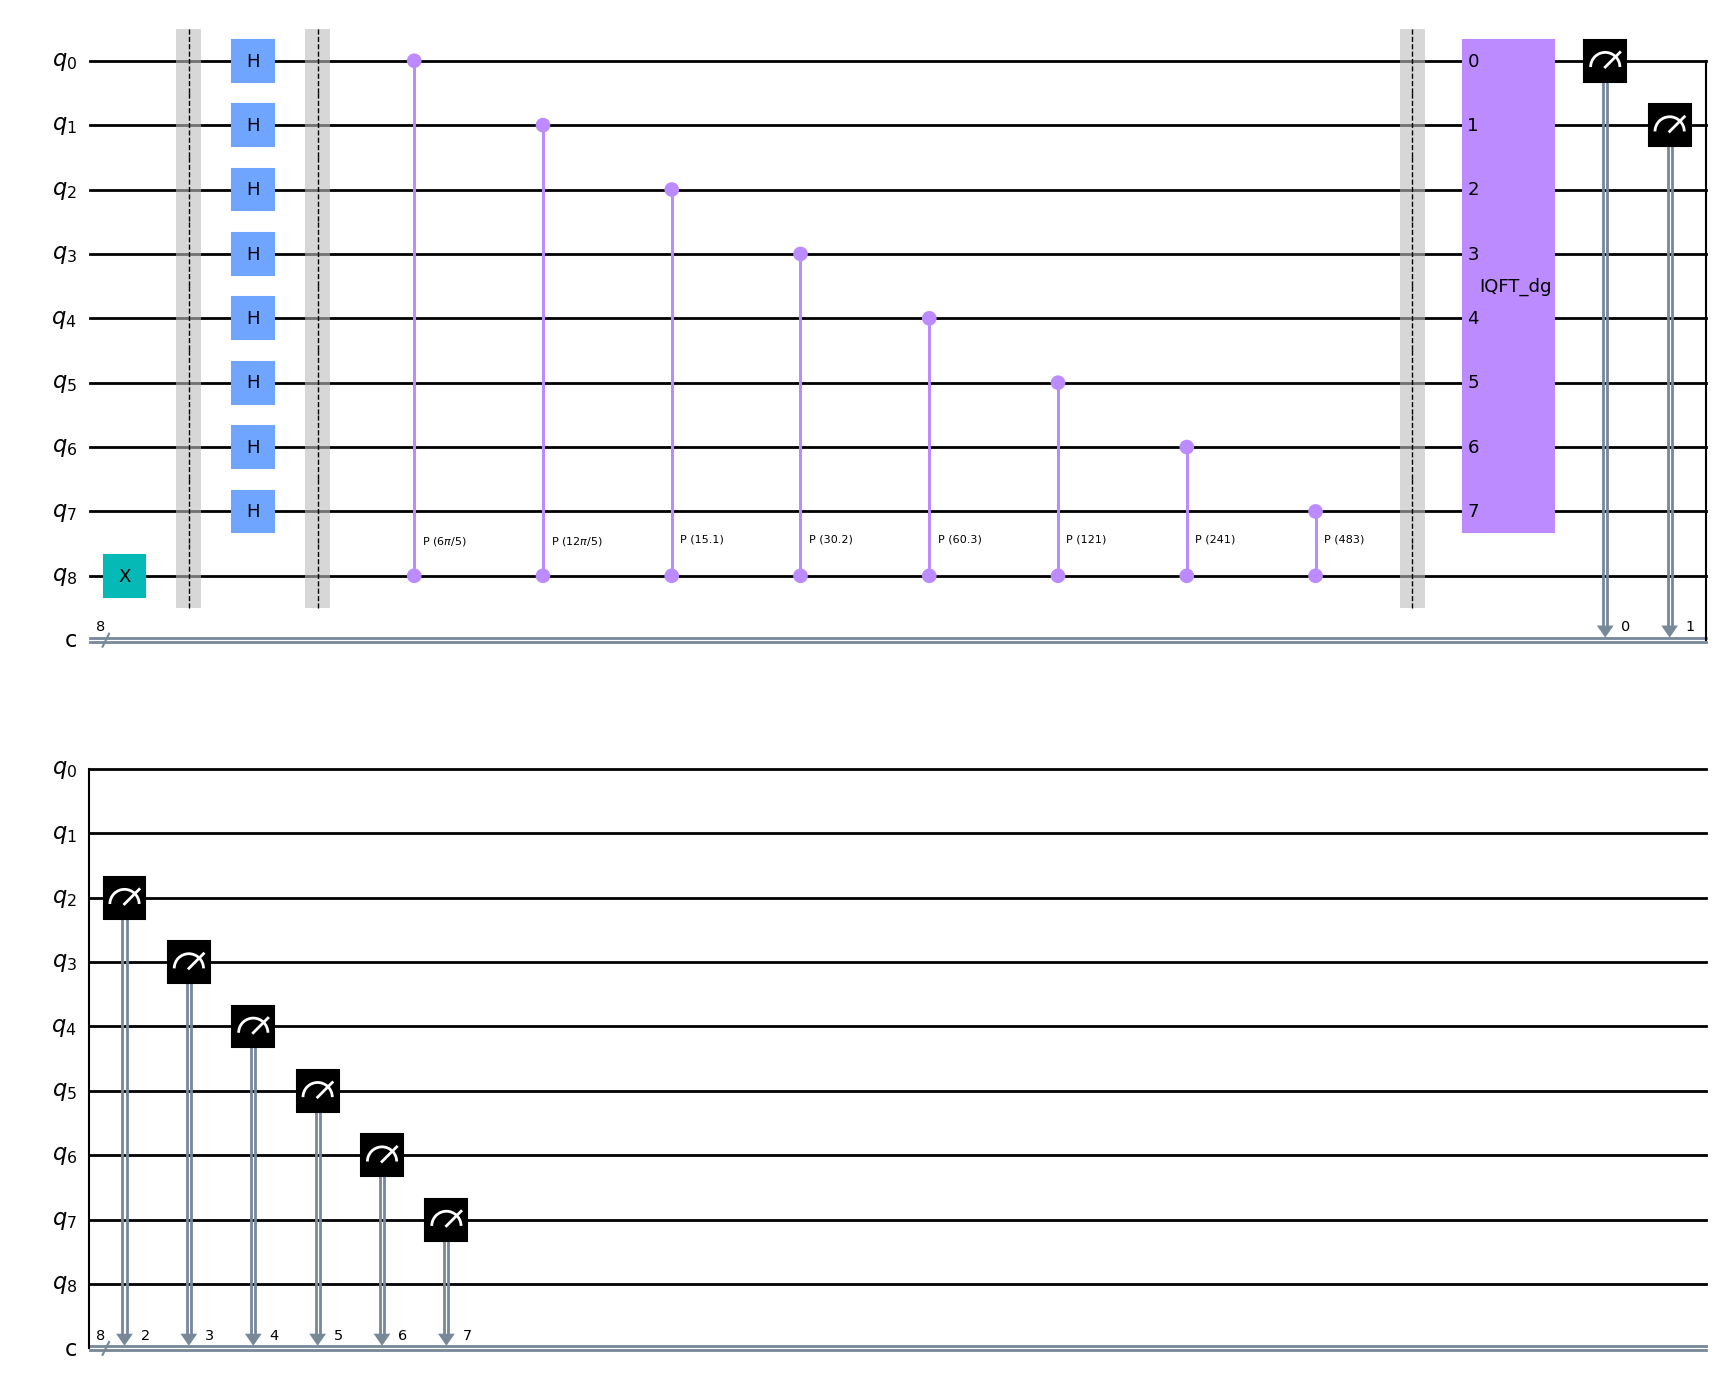

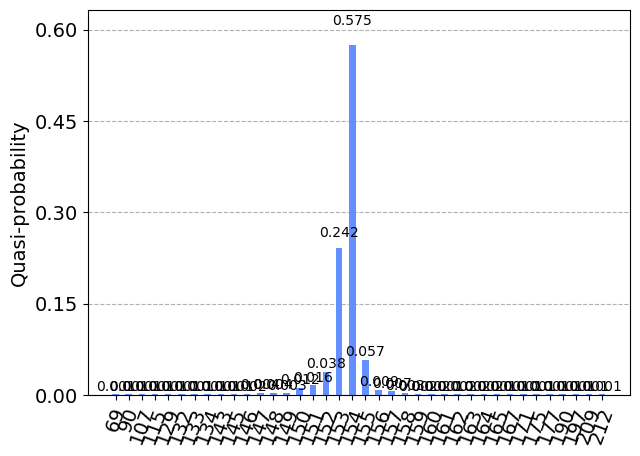

In [72]:
# Phase estimation for up to 8 bits of precision for unitary gate with eigenvalue e^(2 pi i theta)
qc = phase_estimation(8, 0.6)
result = Sampler().run(qc).result()
display(plot_histogram(result.quasi_dists))

In [74]:
# Comparison of mode of distribution to actual value
most_probable = max(result.quasi_dists[0], key=result.quasi_dists[0].get)
most_probable/256

0.6015625

## Shor's Algorithm 

Shor's Algorithm is one of the most famous quantum algorithms, designed to help factor products of two large primes. Classically, this problem is intractible for large primes due to the exponential time complexity of the problem. For this reason, the factoring problem has played an instrumental role in cryptography, as decryption for various protocols utilizes prime factorization when a private key is unavailable. Shor's Algorithm changes this, however, being able to solve the bottleneck of the factoring problem in polynomial time.

To factor numbers via Shor's algorithm, we simply perform a reduction to the order-finding problem, which is detailed as follows:

Suppose we have a positive integer $a$ which is coprime with $N$ (i.e. gcd$(a, N) = 1$). What is the smallest possible integer $r$ such that $a^r \equiv 1 \pmod N$?

To solve the order-finding problem, we can simply perform phase-estimation on a unitary operator representing multiplication by $a$ modulo $N$. Since it is guaranteed that the powers of $a$ modulo $N$ form a cyclic subgroup as asserted in the problem statement, we simply use a permutation matrix to describe this transformation. Due to the fact that this is a permutation matrix, we know that the eigenvalues must lie along the unit circle and that vectors of the following form are eigenvectors: 

$$|\psi_j\rangle = \frac{1}{\sqrt r}\sum_{k = 0} ^{r - 1} \omega_r^{-jk} |a^k\rangle$$

with eigenvalue $\omega_r^j$. It turns out that this eigenvalue $\omega_r = e^\frac{2\pi i}{r}$, meaning that the value computed from phase-estimation $\theta = 1/r$. Hence, if we know an eigenvalue of this permutation matrix, we can compute the order relatively easily.

However, we do not readily have access to these eigenvectors. Nevertheless, since the eigenbasis must span the domain, we can choose a vector such as $|1\rangle$ and rewrite it as a linear combination of eigenvectors. In particular, we have that for eigenvectors $|\psi_k\rangle$,

$$|1\rangle = \frac{1}{\sqrt r}\sum_{k = 0} ^{r - 1}|\psi_k\rangle$$

If we perform phase-estimation, the state of the top $m$ bits representing the measurement of the phase are given by

$$|\gamma_k\rangle = \frac{1}{2^m} \sum_{y = 0} ^{2^m - 1}\sum_{x = 0} ^{2^m - 1}e^{2\pi i x(k/r - y/2^m)}|y\rangle$$

This means that we have an approximation within $y/2^m$ to the value $k/r$ which is chosen uniformly at random among integers between 0 and $r - 1$. Hence, after a few indepedent runs, we can effectively determine the value of $r$ by looking at the intervals between measured values.

Altogether, we have the following algorithm to compute factors:

Input odd composite integer $N$.

1. For $a$ in $\mathbb Z_N^+ \setminus \{1, N\}$:

2. Compute $d = \text{gcd}(a, N)$

3. If $d > 1$, return $b = d$ and $c = N/d$. Else, continue to next step knowing that $a \in \mathbb Z_N^*$

4. Use order-finding to compute order $r$ of $a \pmod n$.

5. If $r$ is even, compute $x = a^{r/2} - 1$, $d = \text{gcd}(x, N)$ (via Euclid's algorithm). If $d > 1$, return $b = d$, $c = N/d$

### Implementation

The following implementation is mostly taken from the original Qiskit book.

In [90]:
def c_amod15(a):
    """
    Controlled multiplication by a mod 15.
    This is hard-coded for simplicity.
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")
    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [4, 11]:
        U.swap(1, 3)
        U.swap(0, 2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

In [91]:
def phase_estimation(
        controlled_operation: QuantumCircuit,
        psi_prep: QuantumCircuit,
        precision: int
    ):
    """
    Generalized algorithm for phase estimation
    """
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True,
            )

    qc.barrier()
    
    # QFT
    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )
    qc.measure(control_register, output_register)
    result = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return result / 2 ** precision

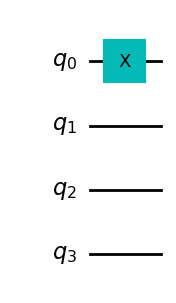

In [92]:
# Loading an initial state 0001 since we do not know any eigenstates
psi_prep = QuantumCircuit(4)
psi_prep.x(0)
display(psi_prep.draw('mpl'))

In [93]:
# Example run of algorithm to find prime factor of 15 with initial guess of 8
from fractions import Fraction
from math import gcd

a = 8
N = 15

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amod15(a),
        psi_prep,
        precision=8
    )
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True


Attempt 1
Non-trivial factor found: 3
